# Machine Learning Modell - Prognose des Erntegewichtes
## Datenanalyse / Datenvorverarbeitung
In einem ersten Schritt werden die Daten von der SQL-Datenbank geladen und analysiert. Dabei interessieren vor allem mögliche Korrelationen der Messwerte der frühen Messdaten mit dem Erntegewicht, um ein Modell für eine möglichst frühe und genaue Prognosse erstellen zu können.

Zudem werden die Daten vorverarbeitet, dazu gehört z.B. das Entfernen von Daten, bei denen kein Gewicht erfasst wurde, und die Skalierung der Daten.

### Datenabfrage aus SQL-DB

In [94]:
%reset

# Datenabfrage von Server-DB
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Liste der Daten, die berücksichtigt werden
dates = ['2019-04-18', '2019-04-25', '2019-05-01', '2019-05-09', '2019-05-16']
#, '2019-05-24', '2019-06-04','2019-06-13', '2019-06-18']

# Verbindungsaufbau
server = 'deepbroccoliserver.database.windows.net'
database = 'DeepBroccoliDatabase'
username = 'ntb'
password = 'brokkoli_2019'
driver= '{SQL Server}'
cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)

# Abfrage definieren und ausführen: Alle Brokkoli mit allen dazugehörigen Messwerten 
query = '''
SELECT dbo.broccoli.id, dbo.broccoli.cropWeight, dbo.broccoli.cropMissing, dbo.broccoli.cropOverripe, 
dbo.broccoli.cropRudimentary, dbo.broccoli.cropRotten, dbo.broccoli.cropUnripe, dbo.broccoli.cropNoBlossom, 
dbo.broccoli.rowNumber, 
dbo.broccolivalues.timestamp, dbo.broccolivalues.pixelCount, 
dbo.broccolivalues.medianNDVI, dbo.broccolivalues.NDVI_15_QUANTILE, dbo.broccolivalues.NDVI_85_QUANTILE,
dbo.broccolivalues.medianNDRE, dbo.broccolivalues.NDRE_15_QUANTILE, dbo.broccolivalues.NDRE_85_QUANTILE
FROM dbo.broccoli inner join dbo.broccolivalues on dbo.broccoli.id = dbo.broccolivalues.id
WHERE dbo.broccoli.id NOT IN (SELECT broccoli_id FROM dbo.broccoliBlacklist)'''

broccoli_data = pd.read_sql_query(query, cnxn)
cnxn.close()

# Describe: Erste Übersicht
broccoli_data.describe()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


,id,cropWeight,rowNumber,pixelCount,medianNDVI,NDVI_15_QUANTILE,NDVI_85_QUANTILE,medianNDRE,NDRE_15_QUANTILE,NDRE_85_QUANTILE
count,22887.000000,21843.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000,22887.000000
mean,1349.298073,554.036671,3.472277,648.906366,0.739324,0.672118,0.789468,0.182191,0.115761,0.242459
std,779.249616,140.956447,1.701254,544.930563,0.118530,0.122626,0.111653,0.092987,0.095642,0.097018
min,1.000000,32.000000,1.000000,2.000000,0.271562,0.235888,0.304524,-0.105472,-0.209394,-0.021634
25%,668.000000,467.000000,2.000000,107.000000,0.670409,0.592363,0.736450,0.111838,0.049254,0.168187
50%,1365.000000,555.000000,3.000000,466.000000,0.783032,0.699072,0.832829,0.167957,0.103573,0.230043
75%,2031.000000,646.000000,5.000000,1182.000000,0.828417,0.763317,0.871457,0.252591,0.178054,0.303814
max,2681.000000,1090.000000,6.000000,3058.000000,0.928941,0.869495,0.957152,0.665100,0.595982,0.744636


### NaN-Werte entfernen, Featurematrix aufbauen

In [95]:
# Daten mit cropWeight == NaN (NULL in Datenbank) entfernen -> Können für Prognose des Gewichtes nicht gebraucht werden
broccoli_data = broccoli_data[~np.isnan(broccoli_data.cropWeight)]
#broccoli_data = broccoli_data[broccoli_data.cropWeight >= 300]

# Erstellung eines DataFrame sodass 1 Zeile pro Brokkoli -> Featurematrix
broccoli_data_fm = broccoli_data[['id', 'cropWeight']].drop_duplicates('id')
columns = ['id', 'pixelCount', 'medianNDVI', 'NDVI_15_QUANTILE', 'NDVI_85_QUANTILE', 'medianNDRE', 'NDRE_15_QUANTILE', 
           'NDRE_85_QUANTILE']

# Für jedes Datum Subset mit Messwerten des Datums erstellen und mit broccoli_data_fm mergen
for date in dates:
    broccoli_data_byDate = broccoli_data[broccoli_data.timestamp == date][columns].add_suffix('_' + date)
    broccoli_data_fm = broccoli_data_fm.merge(broccoli_data_byDate, left_on='id', right_on='id_' + date)
    broccoli_data_fm.drop('id_' + date, axis=1, inplace=True)

print(len(broccoli_data_fm))
broccoli_data_fm.drop('id', axis=1, inplace=True)
broccoli_data_fm.head()

2427


,cropWeight,pixelCount_2019-04-18,medianNDVI_2019-04-18,NDVI_15_QUANTILE_2019-04-18,NDVI_85_QUANTILE_2019-04-18,medianNDRE_2019-04-18,NDRE_15_QUANTILE_2019-04-18,NDRE_85_QUANTILE_2019-04-18,pixelCount_2019-04-25,medianNDVI_2019-04-25,...,medianNDRE_2019-05-09,NDRE_15_QUANTILE_2019-05-09,NDRE_85_QUANTILE_2019-05-09,pixelCount_2019-05-16,medianNDVI_2019-05-16,NDVI_15_QUANTILE_2019-05-16,NDVI_85_QUANTILE_2019-05-16,medianNDRE_2019-05-16,NDRE_15_QUANTILE_2019-05-16,NDRE_85_QUANTILE_2019-05-16
0,504.0,34,0.598546,0.520504,0.632276,0.069624,0.032482,0.158087,55,0.626636,...,0.103831,0.073867,0.140451,418,0.758631,0.681734,0.816258,0.176206,0.129130,0.209370
1,171.0,36,0.476069,0.426748,0.536859,0.071420,0.035913,0.112905,58,0.606818,...,0.107412,0.075764,0.136320,260,0.776217,0.706677,0.833480,0.171147,0.140501,0.206102
2,515.0,24,0.561961,0.518044,0.642913,0.104301,0.068736,0.131910,57,0.632052,...,0.119773,0.088228,0.148527,459,0.765263,0.685852,0.822933,0.171820,0.134007,0.200827
3,306.0,37,0.587593,0.527226,0.638040,0.095604,0.036499,0.139753,51,0.642202,...,0.116147,0.082434,0.147929,334,0.769945,0.692011,0.825063,0.185065,0.147698,0.229014
4,539.0,45,0.559788,0.475788,0.592803,0.079933,0.044615,0.136367,52,0.592289,...,0.098288,0.065154,0.134058,397,0.756830,0.659473,0.816151,0.168476,0.127115,0.203902


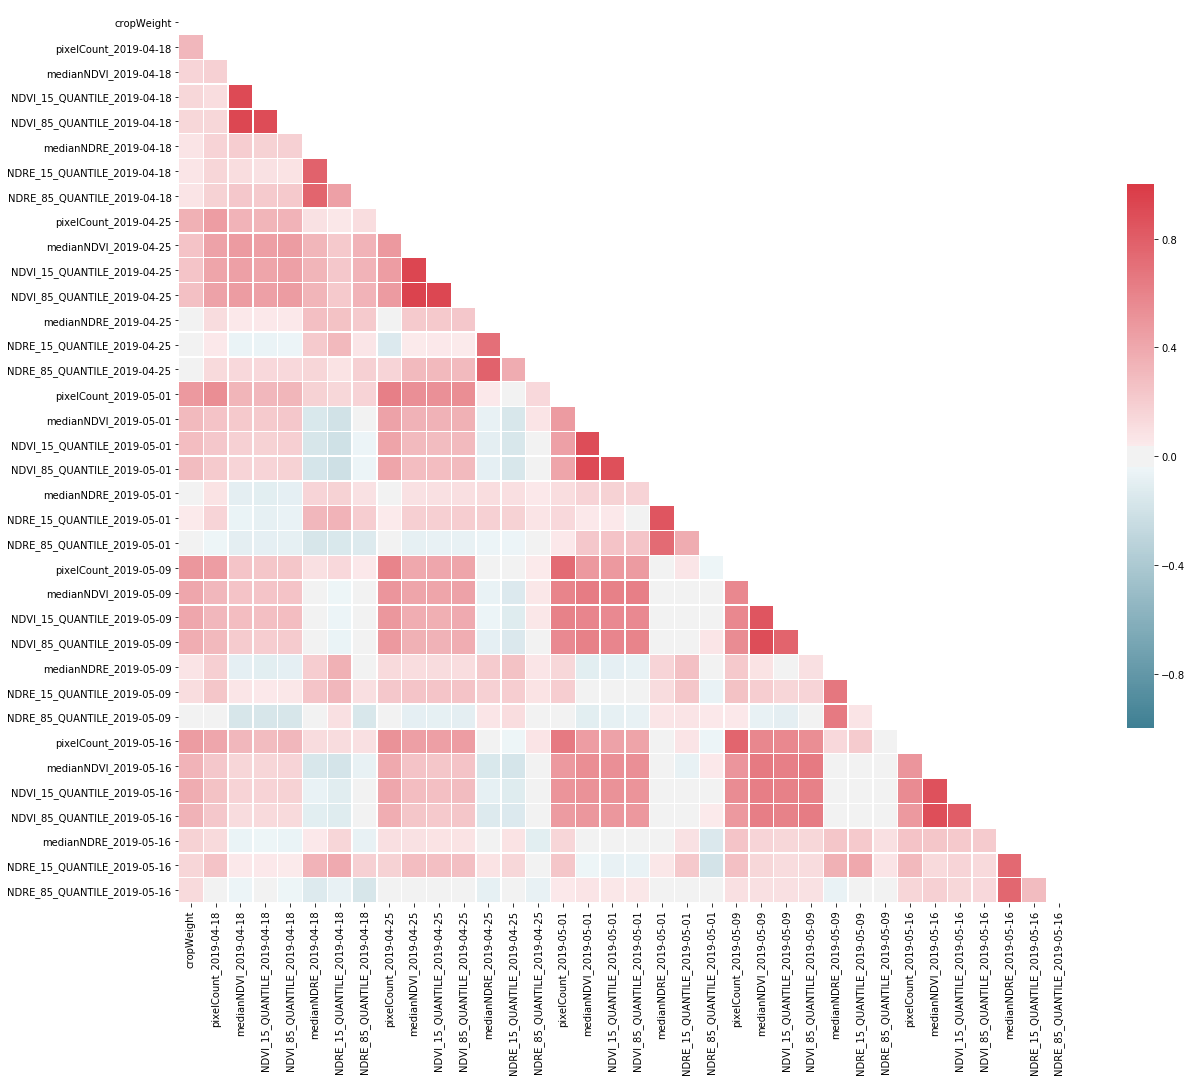

In [96]:
# Korrelationsmatrix erstellen
corr = broccoli_data_fm.corr()

# Seaborn-Plot der Korrelationsmatrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmin=-1, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Man sieht, dass die NDVI-/NDRE-Werte des gleichen Datums (median, 15%-Quantil, 85%-Quantil) sehr stark miteinander korrelieren. Aus diesem Grund wird pro Datum nur noch ein Wert genommen, um die Dimensionen der Featurematrix möglichst zu reduzieren. Behalten wird je das 85%-Quantil, da dieses den "höchsten" Messwert pro Pflanze darstellt und die Korrelation zum Gewicht etwa gleich für alle drei Werte ist.

Zudem sind die Korrelationen mit den NDRE-Werten sehr niedrig. Diese werden daher auch entfernt.

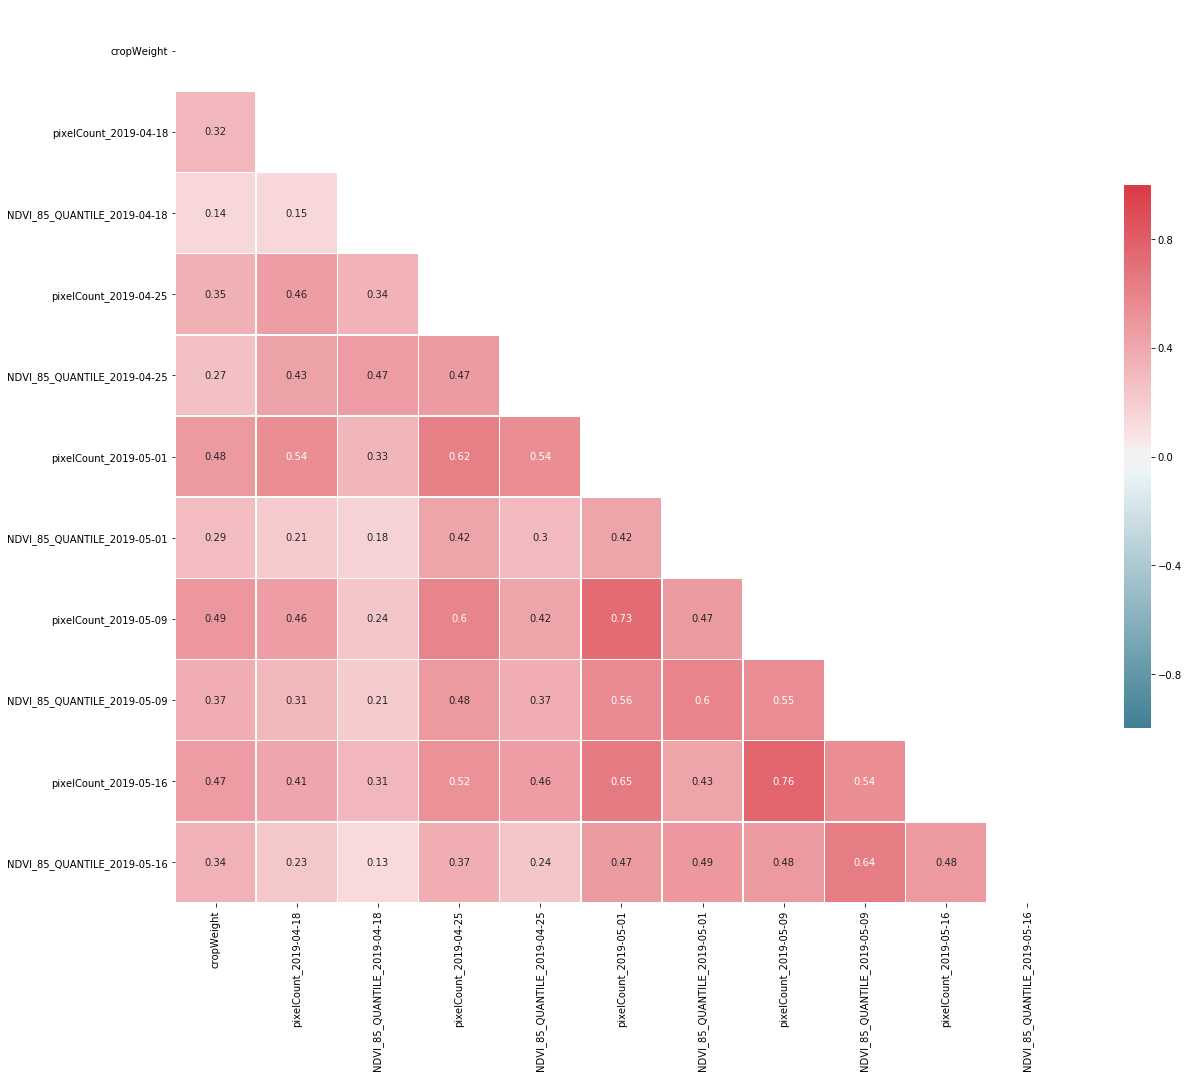

In [97]:
# ALle Spalten mit Median-/15%-Quantil-Werten entfernen, alle NDRE entfernen
columnsUnwanted = broccoli_data_fm.columns[broccoli_data_fm.columns.str.startswith('medianNDVI') | 
                                           broccoli_data_fm.columns.str.startswith('NDVI_15_QUANTILE') | 
                                           broccoli_data_fm.columns.str.startswith('medianNDRE') | 
                                           broccoli_data_fm.columns.str.startswith('NDRE_')]
broccoli_data_fm.drop(columnsUnwanted, axis=1, inplace=True)

# Korrelationsmatrix ohne überflüssige Features
corr = broccoli_data_fm.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, vmin=-1, vmax=1, square=True, linewidths=.5, 
            cbar_kws={"shrink": .5})

### Feature-/Responsematrix erstellen, Test-/Trainingsdaten Split

In [98]:
from sklearn.model_selection import train_test_split

# Featurematrix X, Responsematrix y erstellen
y = broccoli_data_fm['cropWeight']
X = broccoli_data_fm.drop('cropWeight', axis=1)

# Split in Test-/Trainingsdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelle
### Lineare Regression mit StandardScaler
#### Modell mit allen Features
* pixelCount
* NDVI-85%-Quantil

R2-Scores: [0.33629127 0.21662579 0.34415253 0.31663193 0.21516416]
MSE: 13651.2816603273
Mittlerer Betrag der Abweichung: 116.83869932658143


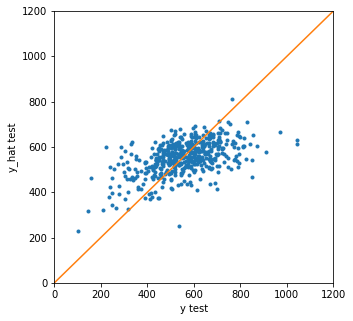

In [99]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

# Pipeline erstellen: StandardScaler -> Lineare Regression
linReg_Pipeline = make_pipeline(StandardScaler(), LinearRegression())

#Schätzen der Parameter
linReg_Pipeline.fit(X_train,y_train)

#5-fach kreuzvalidiertes Bestimmtheitsmass (R2-Score)
scores_linReg = cross_val_score(linReg_Pipeline, X_train,y_train, cv=5)
print('R2-Scores: ' + str(scores_linReg))

# Testdaten predicten und MSE berechnen
y_test_hat_linReg = linReg_Pipeline.predict(X_test)
mse_linReg = mean_squared_error(y_test, y_test_hat_linReg)
print('MSE: ' + str(mse_linReg))
print('Mittlerer Betrag der Abweichung: ' + str(math.sqrt(mse_linReg)))

# Scatterplot y - y_Vorhergesagt erstellen
plt.figure(figsize=(5, 5))
plt.plot(y_test, y_test_hat_linReg, '.')
axes = plt.gca()
axes.set_xlim([0,1200])
axes.set_ylim([0,1200])
axes.set_xlabel('y test')
axes.set_ylabel('y_hat test')
plt.plot(axes.get_xlim(), axes.get_ylim())

#### Modell mit pixelCount

R2-Scores: [0.32179339 0.21010137 0.33164537 0.33306851 0.21225834]
MSE: 13709.711500152063
Mittlerer Betrag der Abweichung: 117.08847723047757


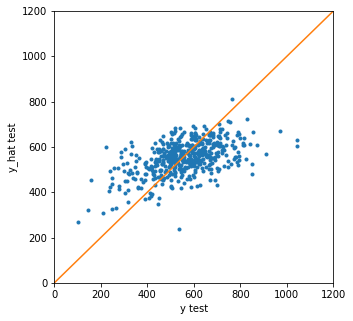

In [100]:
# Matrizen mit nur pixelCount-Features erstellen
X_train_pixelCount = X_train[X_train.columns[X_train.columns.str.startswith('pixelCount')]]
X_test_pixelCount = X_test[X_test.columns[X_test.columns.str.startswith('pixelCount')]]

# Pipeline erstellen: StandardScaler -> Lineare Regression
linReg_Pipeline_pixelCount = make_pipeline(StandardScaler(), LinearRegression())

# Schätzen der Parameter
linReg_Pipeline_pixelCount.fit(X_train_pixelCount, y_train)

# 5-fach kreuzvalidiertes Bestimmtheitsmass (R2-Score)
scores_linReg_pixelCount = cross_val_score(linReg_Pipeline_pixelCount, X_train_pixelCount, y_train, cv=5)
print('R2-Scores: ' + str(scores_linReg_pixelCount))

# Testdaten predicten und MSE berechnen
y_test_hat_linReg_pixelCount = linReg_Pipeline_pixelCount.predict(X_test_pixelCount)
mse_linReg_pixelCount = mean_squared_error(y_test, y_test_hat_linReg_pixelCount)
print('MSE: ' + str(mse_linReg_pixelCount))
print('Mittlerer Betrag der Abweichung: ' + str(math.sqrt(mse_linReg_pixelCount)))

# Scatterplot y - y_Vorhergesagt erstellen
plt.figure(figsize=(5, 5))
plt.plot(y_test, y_test_hat_linReg_pixelCount, '.')
axes = plt.gca()
axes.set_xlim([0,1200])
axes.set_ylim([0,1200])
axes.set_xlabel('y test')
axes.set_ylabel('y_hat test')
plt.plot(axes.get_xlim(), axes.get_ylim())

R2-Scores: [0.22317379 0.09480545 0.19742352 0.18853592 0.13378078]
MSE: 15463.749337425279
Mittlerer Betrag der Abweichung: 124.35332459337498


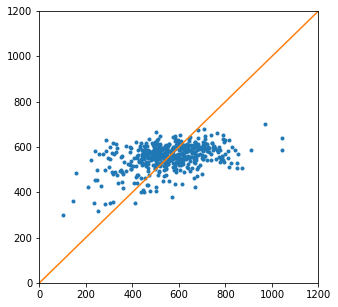

In [101]:
# Matrizen mit nur NDVI-Features erstellen
X_train_NDVI = X_train[X_train.columns[X_train.columns.str.startswith('NDVI')]]
X_test_NDVI = X_test[X_test.columns[X_test.columns.str.startswith('NDVI')]]

# Pipeline erstellen: StandardScaler -> Lineare Regression
linReg_Pipeline_NDVI = make_pipeline(StandardScaler(), LinearRegression())

# Schätzen der Parameter
linReg_Pipeline_NDVI.fit(X_train_NDVI, y_train)

# 5-fach kreuzvalidiertes Bestimmtheitsmass (R2-Score)
scores_linReg_NDVI = cross_val_score(linReg_Pipeline_NDVI, X_train_NDVI, y_train, cv=5)
print('R2-Scores: ' + str(scores_linReg_NDVI))

# Testdaten predicten und MSE berechnen
y_test_hat_linReg_NDVI = linReg_Pipeline_NDVI.predict(X_test_NDVI)
mse_linReg_NDVI = mean_squared_error(y_test, y_test_hat_linReg_NDVI)
print('MSE: ' + str(mse_linReg_NDVI))
print('Mittlerer Betrag der Abweichung: ' + str(math.sqrt(mse_linReg_NDVI)))

# Testdaten predicten und Scatterplot y - y_Vorhergesagt erstellen
plt.figure(figsize=(5, 5))
plt.plot(y_test, y_test_hat_linReg_NDVI, '.')
axes = plt.gca()
axes.set_xlim([0,1200])
axes.set_ylim([0,1200])
plt.plot(axes.get_xlim(), axes.get_ylim())

#### Fazit Modelle lineare Regression, für Daten '2019-04-18', '2019-04-25', '2019-05-01', '2019-05-09', '2019-05-16'
1. Die Modelle mit pixelCount (pixelCount, pixelCount + NDVI) sind ähnlich gut vom MSE her, das Modell mit nur dem NDVI ist leicht schlechter
2. Der MSE ist recht hoch, sagt aber an sich nicht viel aus. Der mittlere Betrag der Abweichung beträgt für alle Modelle über 110 (g), was bei einem Gewicht der Brokkoli von 200g-1000g recht viel zu sein scheint
3. Wenn ganz am Anfang alle Brokkoli mit einem Gewicht unter 300g entfernt werden, wird der mittlere Fehlerbetrag etwas kleiner bzw. ca. 10 (g) genauer
4. Wenn noch die nächsten ein bzw. zwei Daten hinzugenommen werden, ändert sich an der Vorhersagegenauigkeit wenig. ab dem 25.04.19 scheint ein Punkt erreicht, wo durch die höhere Abdeckung des Feldes die Voronoi-Zellen beinahe oder ganz ausgefüllt sind und so der Informationsgewinn nicht wirklich gegeben ist, da nicht mehr korrekt segmentiert werden kann.

In [102]:
# Ausgabe mittlerer Gewichte
print('Mittleres Gewicht aller Brokkoli: ' + str(broccoli_data['cropWeight'].mean()))
print('Mittleres Gewicht der Brokkoli im Testdatensatz: ' + str(np.mean(y_test)))

Mittleres Gewicht aller Brokkoli: 554.0366707869798
Mittleres Gewicht der Brokkoli im Testdatensatz: 557.0123456790124


### Polynomiale Regression
#### Modell mit allen Features
* pixelCount
* NDVI-85%-Quantil

Grad: 2
R2-Scores: [0.28639909 0.15707151 0.34793158 0.32577681 0.21471785]
MSE: 14303.04775896448
Mittlerer Betrag der Abweichung: 119.59535007250274


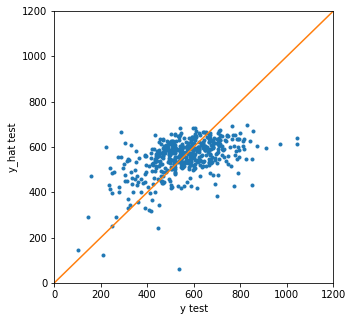


Grad: 3
R2-Scores: [-0.30975446 -0.23951153  0.19550705 -1.44597018 -0.02243106]
MSE: 22193.24833668841
Mittlerer Betrag der Abweichung: 148.97398543600963


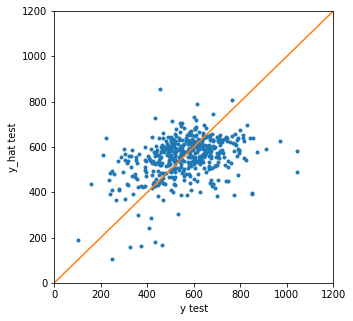


Grad: 4
R2-Scores: [-24.77069664 -21.9281216   -4.60604888 -16.0579472  -11.97047215]
MSE: 85326.1216278829
Mittlerer Betrag der Abweichung: 292.10635328229836


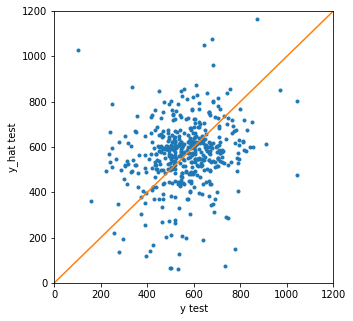


Grad: 5
R2-Scores: [-1162.30370271 -1169.03561522  -244.48959395 -1228.53914354
 -1374.23233309]
MSE: 3771809.721058313
Mittlerer Betrag der Abweichung: 1942.1147548634485


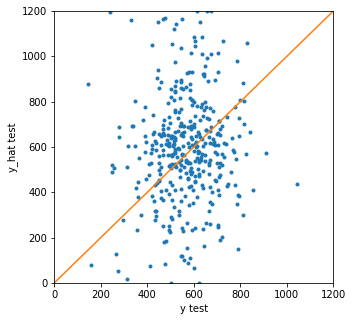

In [103]:
from sklearn.preprocessing import PolynomialFeatures

# Grade für PolynomialFeatures
degrees = np.arange(2, 6)

for i, degree in enumerate(degrees):
    print('Grad: ' + str(degree))
    # Pipeline erstellen: PolynomialFeatures -> Lineare Regression
    poly_Pipeline = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    #Schätzen der Parameter
    poly_Pipeline.fit(X_train,y_train)

    #5-fach kreuzvalidiertes Bestimmtheitsmass (R2-Score)
    scores_poly = cross_val_score(poly_Pipeline, X_train,y_train, cv=5)
    print('R2-Scores: ' + str(scores_poly))

    # Testdaten predicten und MSE berechnen
    y_test_hat_poly = poly_Pipeline.predict(X_test)
    mse_poly = mean_squared_error(y_test, y_test_hat_poly)
    print('MSE: ' + str(mse_poly))
    print('Mittlerer Betrag der Abweichung: ' + str(math.sqrt(mse_poly)))

    # Scatterplot y - y_Vorhergesagt erstellen
    plt.figure(figsize=(5, 5))
    plt.plot(y_test, y_test_hat_poly, '.')
    axes = plt.gca()
    axes.set_xlim([0,1200])
    axes.set_ylim([0,1200])
    axes.set_xlabel('y test')
    axes.set_ylabel('y_hat test')
    plt.plot(axes.get_xlim(), axes.get_ylim())
    plt.show()
    
    print()

### Neuronale Netze - MLP
Im Folgenden wird ein MLP (Multilayer-Perzeptron) erstellt, welches die gleichen Input-Daten wie die linearen Regressions-Modelle verwendet und mittels Backpropagation optimiert wird.

MSE: 13767.472095961672
Mittlerer Betrag der Abweichung: 117.33487161096514


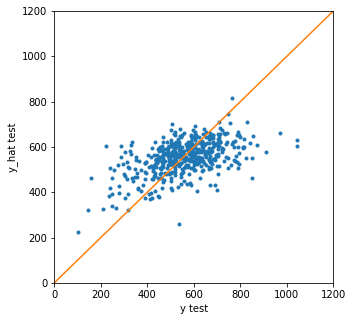

In [107]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe_MLPRegressor = Pipeline([('scaler',  StandardScaler()), ('MLPRegressor', MLPRegressor())])
grid_params_MLPRegressor = [{
    'MLPRegressor__solver': ['lbfgs'],
    'MLPRegressor__max_iter': [100,200,300,500],
    'MLPRegressor__activation' : ['relu','logistic','tanh'],
    'MLPRegressor__hidden_layer_sizes':[(5,), (10,), (10,5), (10,10)] }]


CV_mlpregressor = GridSearchCV (estimator = pipe_MLPRegressor,
                               param_grid = grid_params_MLPRegressor,
                               cv = 5,return_train_score=True, verbose=0)

CV_mlpregressor.fit(X_train, y_train)

y_test_hat_mlp=CV_mlpregressor.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_test_hat_mlp)
print('MSE: ' + str(mse_mlp))
print('Mittlerer Betrag der Abweichung: ' + str(math.sqrt(mse_mlp)))


# Testdaten predicten und Scatterplot y - y_Vorhergesagt erstellen
plt.figure(figsize=(5, 5))
plt.plot(y_test, y_test_hat_mlp, '.')
axes = plt.gca()
axes.set_xlim([0,1200])
axes.set_ylim([0,1200])
axes.set_xlabel('y test')
axes.set_ylabel('y_hat test')
plt.plot(axes.get_xlim()+[50, axes.get_ylim())